# Image Style Transfer  using convolutional neural networks


It is an interpretation of the paper [Image Style Transfer Using Convolutional Neural Networks, by Gatys](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf) using PyTorch.

To do the style transfer the VGG-19 network is used with its pretrained features. It consists of 5 convolutional neural layers and 3 fully connected layers. For the process, the style of an image and the content of another are separated, and a new third image is optimized with the style and content of the previously selected. With some iteratios the target image will have the selected result.

## Import libraries

In [20]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Load the network architecture

In [21]:
# get the "features" portion of VGG19 (I will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since I'am only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [22]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Load Content and Style Images

First a pair of helper functions are added for loading the image as normalized tensors and then another one to convert it again to a numpy image. It is easier to work with tensors and smaller images for deep learning.

In [23]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    
    image = Image.open(img_path).convert('RGB')
    
    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)
    
    if shape is not None:
        size = shape
        
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)    
    return image

# helper function for un-normalizing an image 
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    
    return image

Then load the content and style images

In [24]:
# load in content and style image
content = load_image('/magritte.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/delaunay.jpg', shape=content.shape[-2:]).to(device)

---
## VGG19 Layers

The images are passed through the VGG-19 network until the desired output is obtained

In [25]:
# print out VGG19 structure to see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

In [26]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """
    
    ## Mapping layer names of PyTorch's VGGNet
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                 '5': 'conv2_1',
                 '10': 'conv3_1',
                 '19': 'conv4_1',
                 '21': 'conv4_2',
                 '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

---
## Gram Matrix 

The output of every convolutional layer is a Tensor with dimensions associated with the `batch_size`, a depth, `d` and some height and width (`h`, `w`). The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose 

In [27]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor 
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    ## get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    ## reshape it, so I'm multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    ## calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram 

## Putting it all Together

Now that I've written functions for extracting features and computing the gram matrix of a given convolutional layer; let's put all these pieces together! I'll extract features from the images and calculate the gram matrices for each layer in my style representation.

In [28]:
# get content and style features only once before forming the target image
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of the style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of the *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

Below, I weight the style representation at each relevant layer. It's suggested to use a range between 0-1 to weight these layers. By weighting earlier layers (`conv1_1` and `conv2_1`) more, I expect to get _larger_ style artifacts in my resulting, target image. Should I choose to weight later layers, I'll get more emphasis on smaller features. This is because each layer is a different size and together they create a multi-scale style representation!

#### Content and Style Weight

Just like in the paper, I define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ my final image is. It's recommended to leave the content_weight = 1 and set the style_weight to achieve the desired ratio.

In [29]:
# weights for each style layer 
# weighting earlier layers more will result in *larger* style artifacts
# notice I am excluding `conv4_2` from content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

## Updating the Target & Calculating Losses

Now, I'll decide on a number of steps for which to update the image (I am changing the _target_ image and nothing else about VGG19 or any other image). I recommend using at least 2000 steps for good results.

Inside the iteration loop, I calculate the content and style losses and update the target image, accordingly.

The **content loss** will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows: 
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

The **style loss** is calculated in a similar way, only I have to iterate through a number of layers, specified by name in the dictionary `style_weights`. 
> I'll calculate the gram matrix for the target image, `target_gram` and style image `style_gram` at each of these layers and compare those gram matrices, calculating the `layer_style_loss`.

Finally, I'll create the **total loss** by adding up the style and content losses and weighting them with the specified alpha and beta!

Total loss:  9203194880.0


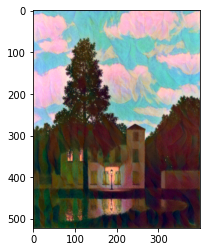

Total loss:  3587084032.0


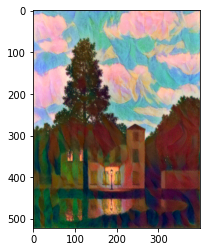

Total loss:  1531429760.0


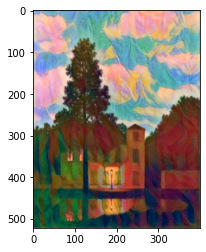

Total loss:  743722624.0


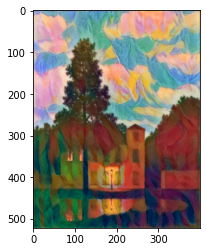

Total loss:  420626240.0


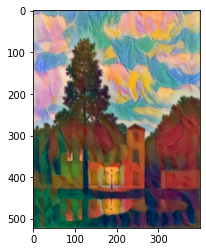

In [30]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update the image (5000)

for ii in range(1, steps+1):
    
    # get the features from the target image    
    target_features = get_features(target, vgg)
    
    # then calculate the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # iterate through each style layer and add to the style loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        _, d, h, w = target_feature.shape
        
        # get the target gram matrix
        target_gram = gram_matrix(target_feature)
        
        # get the "style" style representation
        style_gram = style_grams[layer]
        
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
        
    # the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update the target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

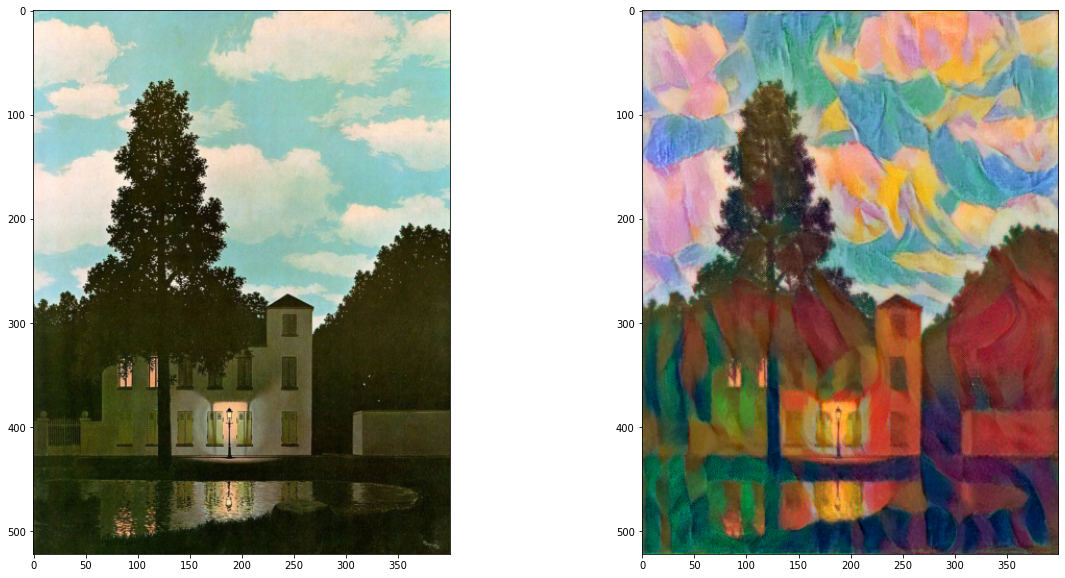

In [31]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
ax1.imshow(im_convert(content))
ax2.imshow(im_convert(target))